![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/DEID_DICOM_IMAGE.ipynb)

# **Deidentify DICOM Images**
Deidentify text and metada

To run this yourself, you will need to upload your **Spark OCR & Sprk NLP** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

# 1. Colab Setup

Read License Key

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()
os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

Install Dependencies

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.0.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip -q install --upgrade spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION\+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

Importing Libraries

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
import sparkocr
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

# import sparknlp packages
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

Start Spark Session

In [3]:
# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION,
                       nlp_secret=SECRET,
                       nlp_internal=JSL_VERSION
                       )
spark

Spark version: 3.0.2
Spark NLP version: 3.3.4
Spark OCR version: 3.9.1



# 2. Download and read DICOM Image

Download Image

In [49]:
!wget https://github.com/JohnSnowLabs/spark-ocr-workshop/raw/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm -O image.dcm

--2022-01-10 19:49:17--  https://github.com/JohnSnowLabs/spark-ocr-workshop/raw/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm [following]
--2022-01-10 19:49:17--  https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-brains-front-medical-3.dcm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3836142 (3.7M) [application/octet-stream]
Saving to: ‘image.dcm’

image.dcm           100%[========

In [50]:
image_df = spark.read.format("binaryFile").load('image.dcm').cache()
image_df.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/content/ima...|2022-01-10 19:49:...|3836142|[02 00 01 00 4F 4...|
+--------------------+--------------------+-------+--------------------+



Read Image and metadata


    Image #0:
    Origin: file:/content/image.dcm
    Resolution: 0 dpi
    Width: 1520 px
    Height: 841 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


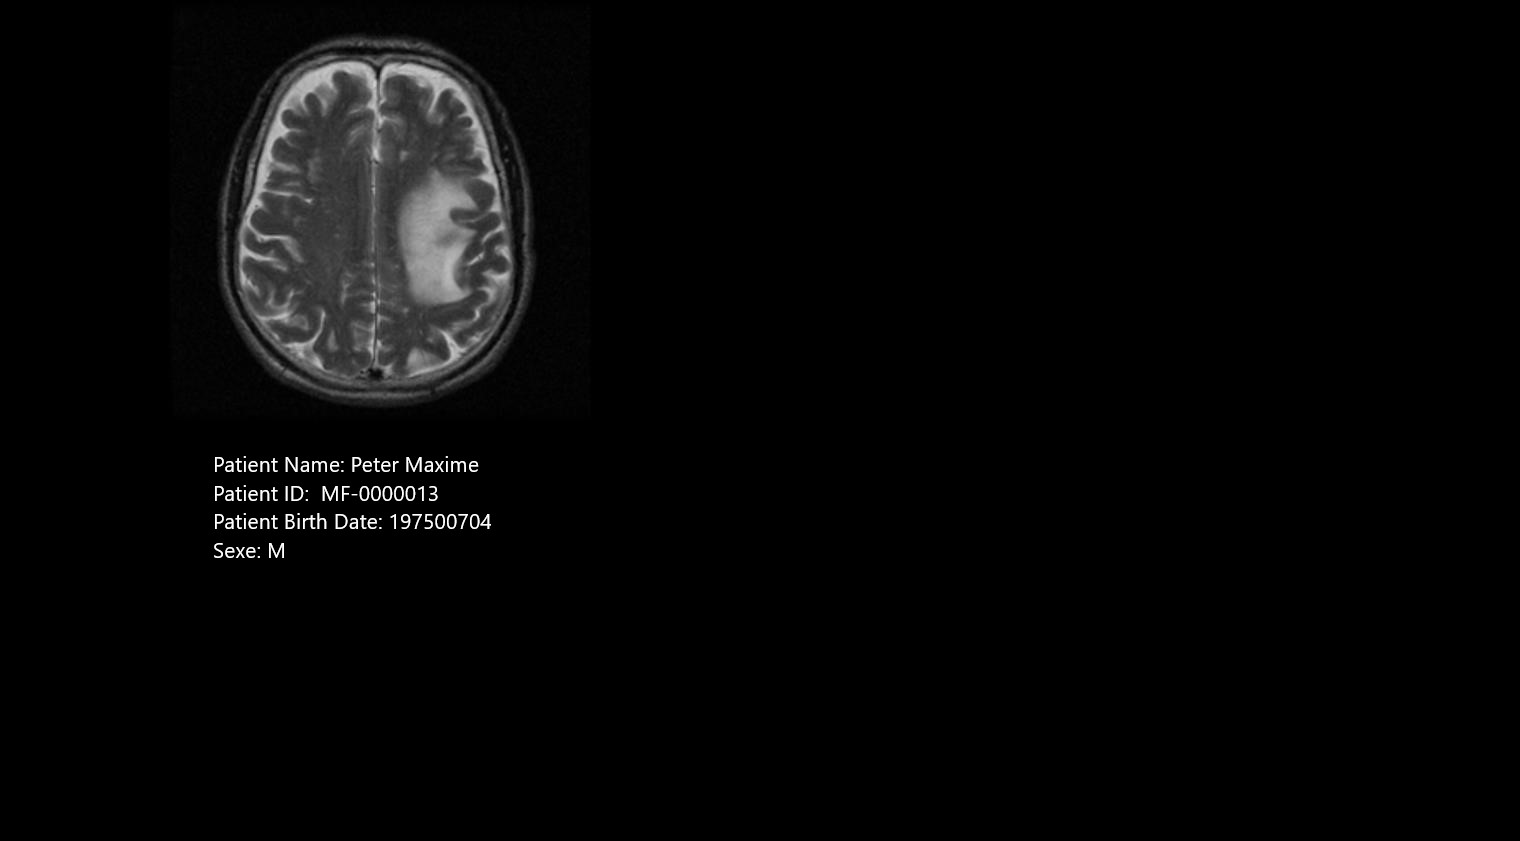


    Image #0:
    Origin: file:/content/image.dcm
    Resolution: 0 dpi
    Width: 1520 px
    Height: 841 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


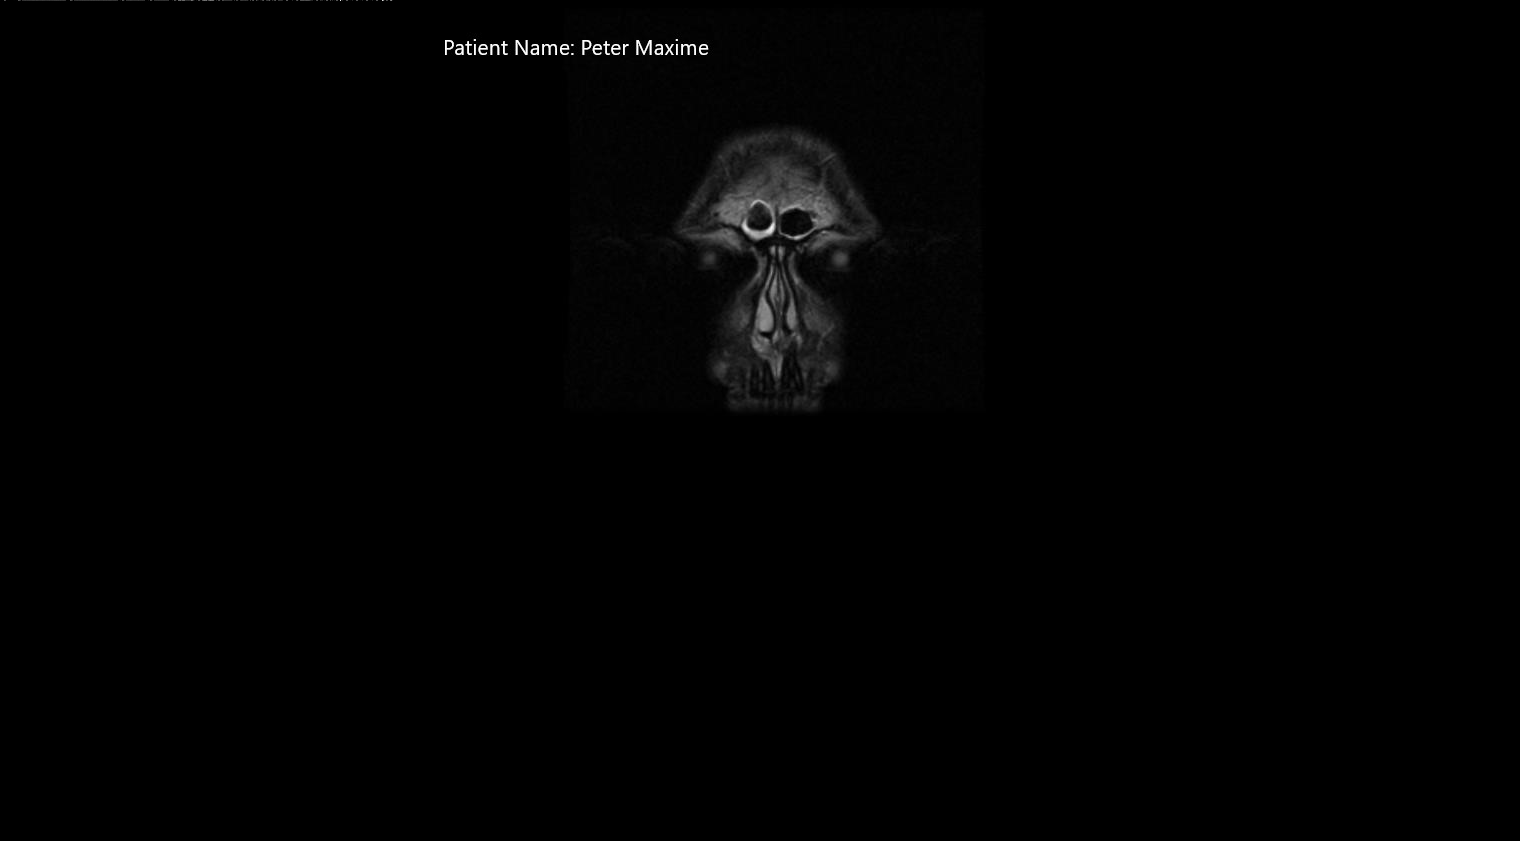


    Image #0:
    Origin: file:/content/image.dcm
    Resolution: 0 dpi
    Width: 1520 px
    Height: 841 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


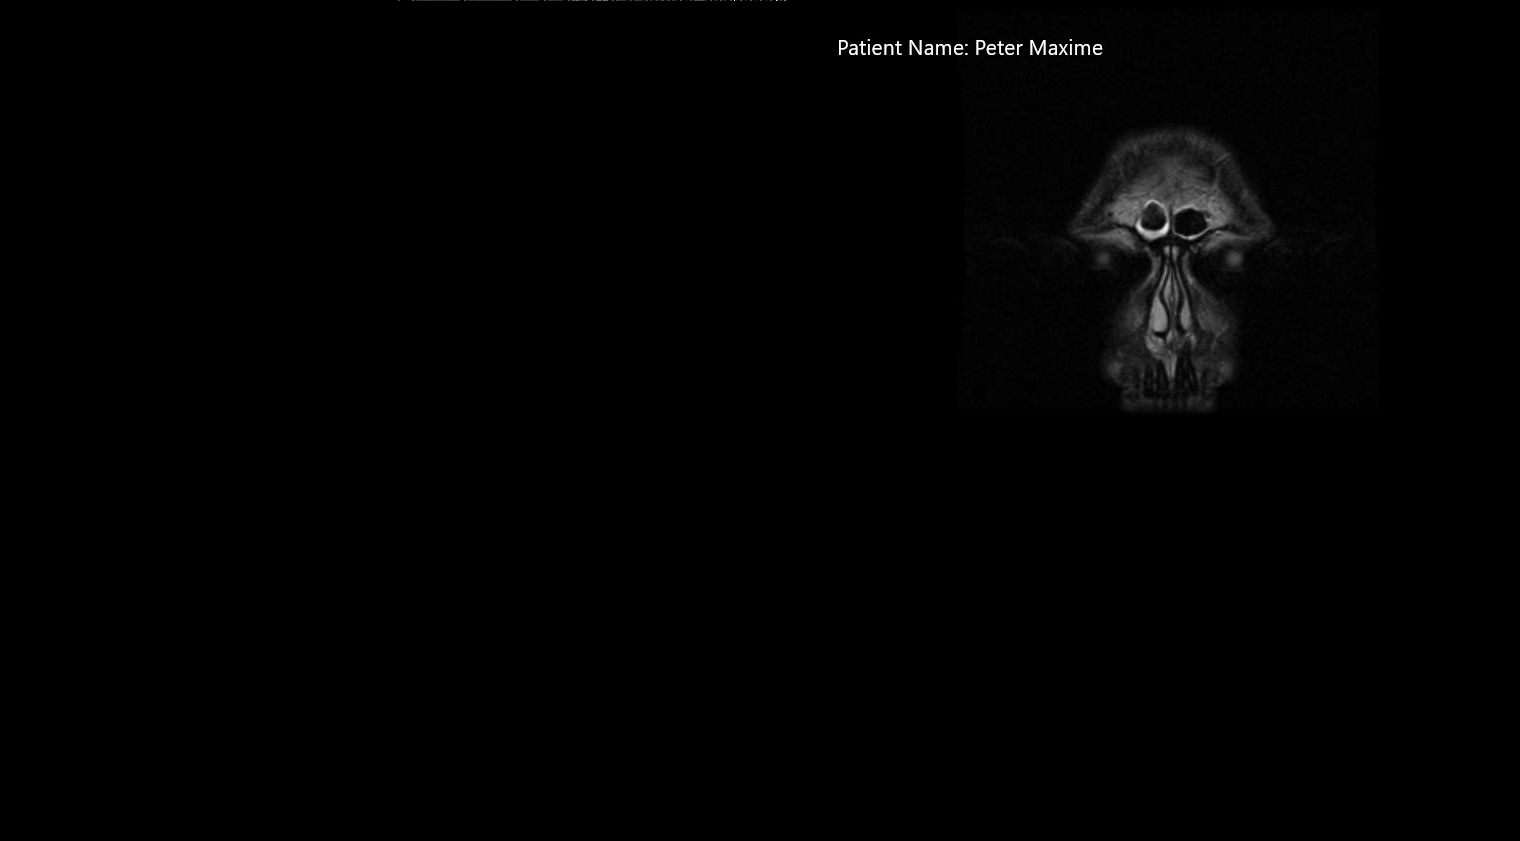

In [51]:
for image in DicomToImage().transform(image_df).collect():
  #print(image.exception)
  #print(image.metadata)
  display_image(image.image)

# 3. Construct OCR and DEID (NLP) Pipelines

Deidentification Pipeline

In [7]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

OCR and Metadata Deidentification.

In [78]:
# Extract jpg images from Dicom images
# Set deidentify metadata to True
dicom_to_image = DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

adaptive_thresholding = ImageAdaptiveThresholding() \
    .setInputCol("image_raw") \
    .setOutputCol("corrected_image") \
    .setBlockSize(47) \
    .setOffset(4) \
    .setKeepInput(True)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("corrected_image") \
    .setOutputCol("text") \
    #.setIgnoreResolution(False) \
    #.setOcrParams(["preserve_interword_spaces=0"])

# Found sensitive data using DeIdentificationModel
deidentification_rules = DeIdentificationModel.pretrained("deidentify_rb_no_regex", "en", "clinical/models") \
    .setInputCols(["metadata_sentence", "metadata_token","metadata_ner_chunk"]) \
    .setOutputCol("deidentified_metadata_raw")

finisher = Finisher() \
    .setInputCols(["deidentified_metadata_raw"]) \
    .setOutputCols("deidentified_metadata") \
    .setOutputAsArray(False) \
    .setValueSplitSymbol("") \
    .setAnnotationSplitSymbol("")

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(100) \
    .setPadding(1)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True)

# Store image back to Dicom document
imageToDicom = ImageToDicom() \
    .setInputCol("image_with_regions") \
    .setOutputCol("dicom") \
    #.setInputMetadata("deidentified_metadata")

# OCR pipeline
pipeline = Pipeline(stages=[
    dicom_to_image,
    adaptive_thresholding,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    position_finder,
    drawRegions,
    imageToDicom
])

deidentify_rb_no_regex download started this may take some time.
Approximate size to download 8.9 KB
[OK!]
deidentify_rb_no_regex download started this may take some time.
Approximate size to download 8.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


# 4. Run the pipelines and save Deidentified Dicom Image

In [80]:
de_dicom_df = pipeline.fit(image_df).transform(image_df)
de_dicom_df.columns

['path', 'dicom', 'exception']

In [81]:
de_dicom_df.show()

+--------------------+--------------------+---------+
|                path|               dicom|exception|
+--------------------+--------------------+---------+
|file:/content/ima...|[02 00 01 00 4F 4...|         |
+--------------------+--------------------+---------+



In [84]:
de_dicom_df = pipeline.fit(image_df).transform(image_df).cache()

output_path = "./"

for r in de_dicom_df.select("dicom", "path").collect():
    path, name = os.path.split(r.path)
    filename_split = os.path.splitext(name)
    file_name = os.path.join(output_path, filename_split[0]+".dcm")
    print(f"Storing to {file_name}")
    with open(file_name, "wb") as file:
        file.write(r.dicom)

Storing to ./image.dcm


# 5. Load Deidentified Dicom Images and Visualize Results


    Image #0:
    Origin: file:/content/image.dcm
    Resolution: 0 dpi
    Width: 1520 px
    Height: 841 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


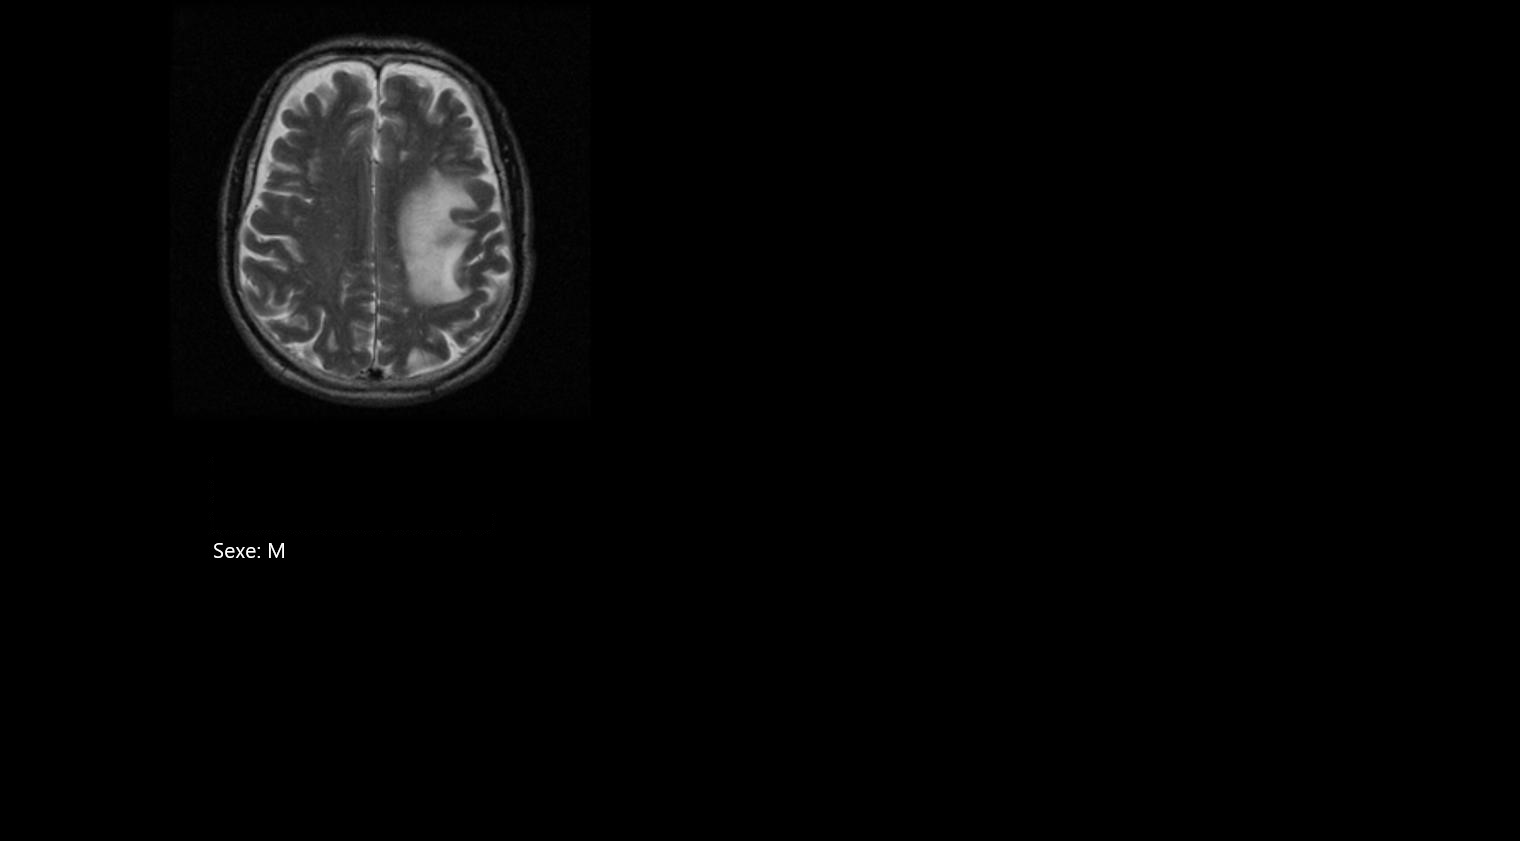


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.324227860973032955003270142769571823751"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.129671487991609648213376054123398193196"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.4.0rc1"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        "vr": "CS"
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {

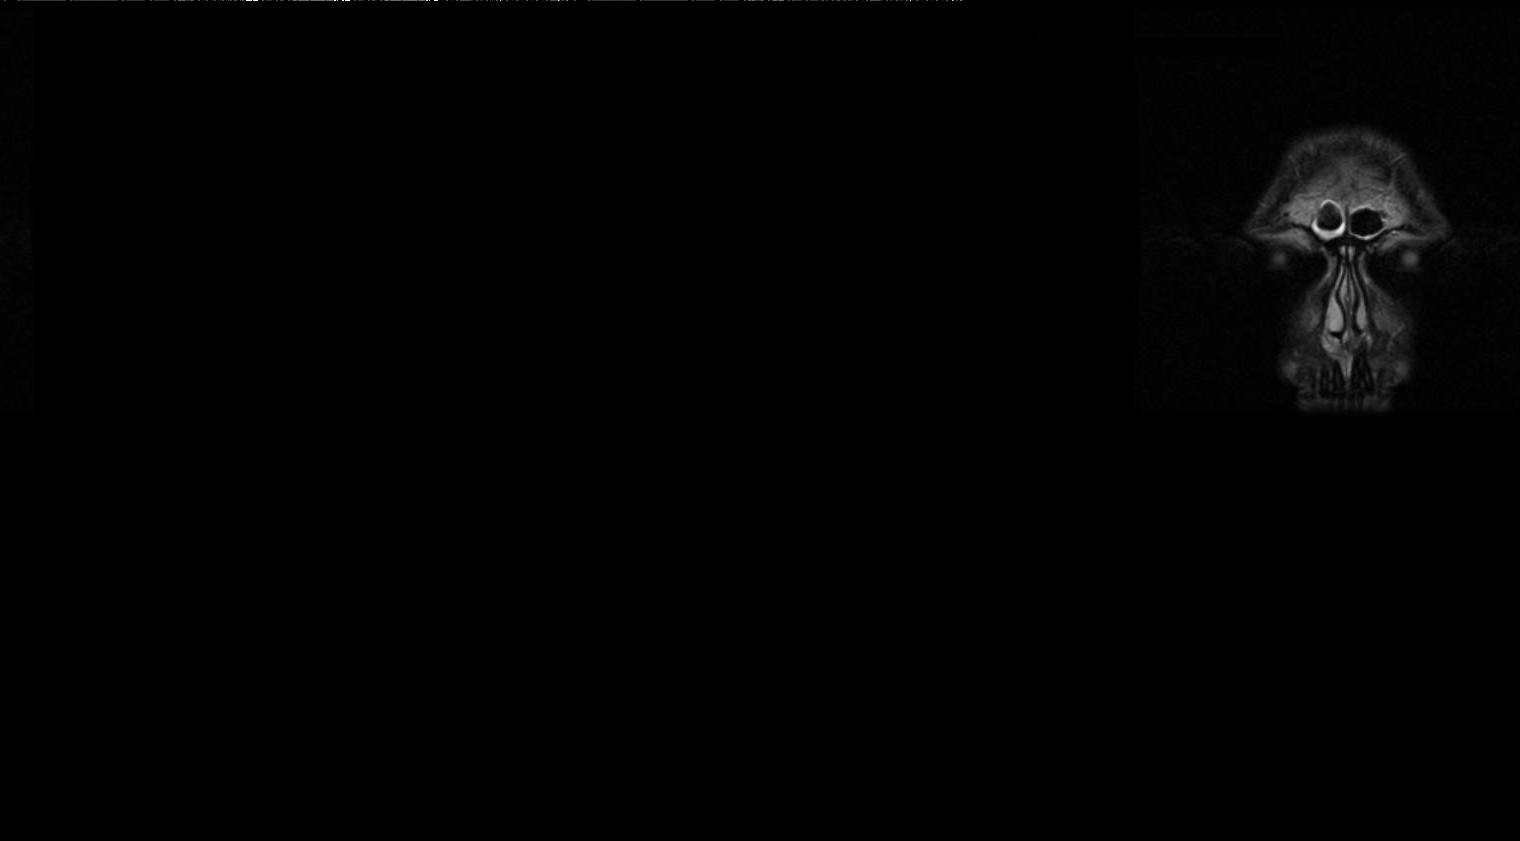


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.324227860973032955003270142769571823751"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.129671487991609648213376054123398193196"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.4.0rc1"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        "vr": "CS"
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {

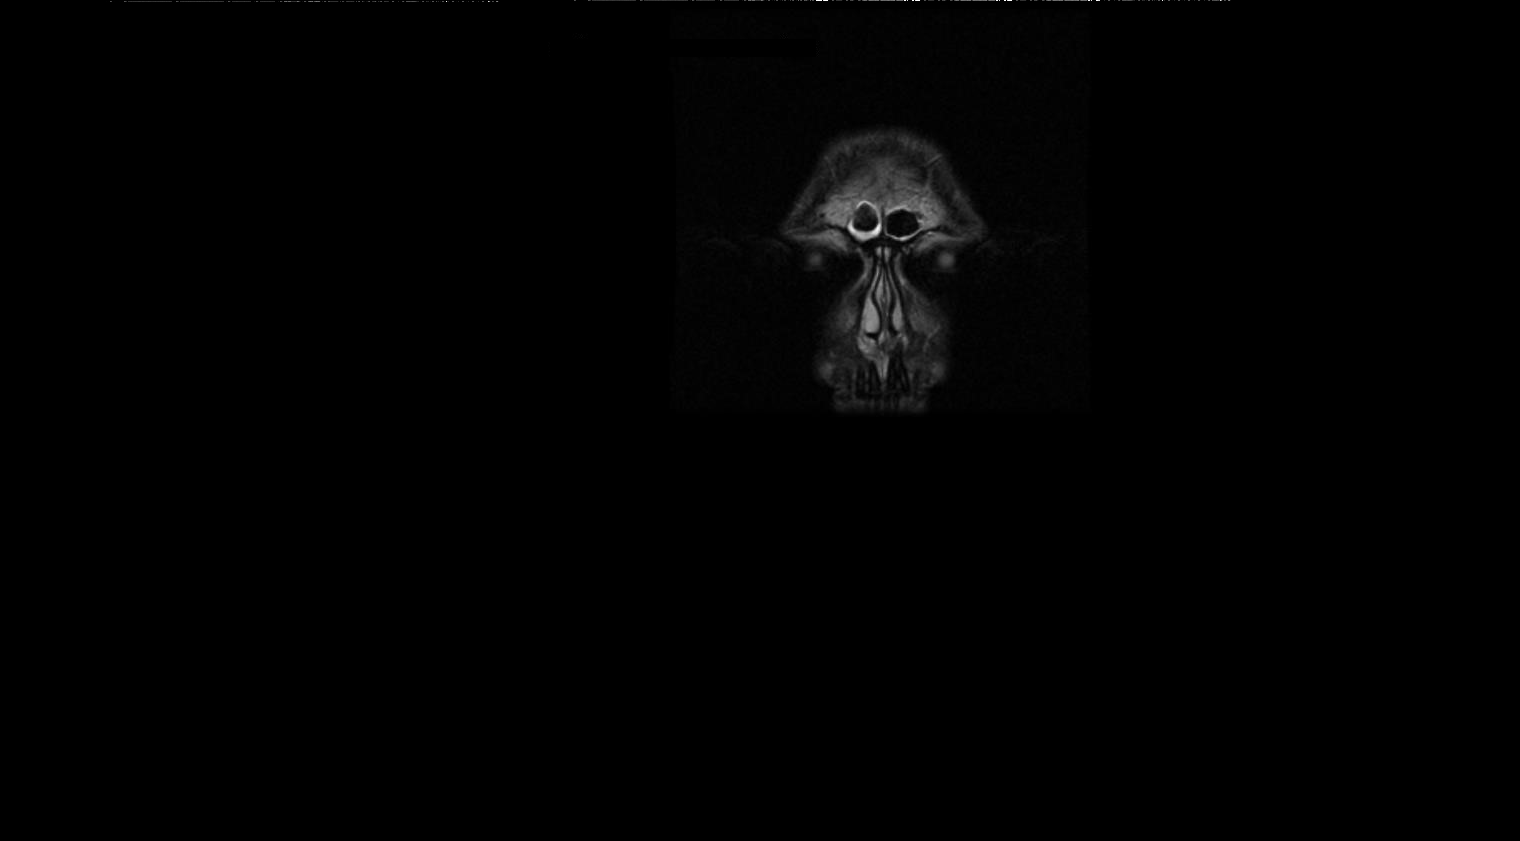


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.324227860973032955003270142769571823751"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.129671487991609648213376054123398193196"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.4.0rc1"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        "vr": "CS"
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {

In [85]:
dicom_gen_df = spark.read.format("binaryFile").load("./*.dcm")
de_dicom_gen_df = DicomToImage().transform(dicom_gen_df)
for r in de_dicom_gen_df.select("image", "metadata").collect():
    display_image(r.image)
    print(r.metadata)